### Bird Classifier

#### Reference
- https://course.fast.ai/Lessons/lesson1.html
- https://docs.fast.ai/
- https://timm.fast.ai/
- https://huggingface.co/microsoft/resnet-18


In [1]:
# !pip install -Uqq fastai
# !pip install -Uqq duckduckgo_search

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Search for bird image

url: https://2.bp.blogspot.com/-LZ4VixDdVoE/Tq0ZhPycLsI/AAAAAAAADDM/OKyayfW-z4U/s1600/beautiful_Birds_wallpapers_pictures_Kingfisher_Lilac+Breasted+Roller+Bird.JPG


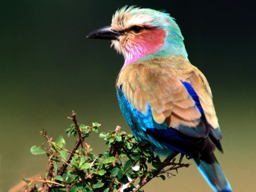

In [6]:
urls = search_images("bird photos", 1)
print("url: %s" % (urls[0]))

#download the image
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

### Step 1 - Download images for training model

In [8]:
keywords = 'forest', 'bird'
path = Path('bird_or_not')

for kw in keywords:
    dest = (path/kw)
    dest.mkdir(exist_ok=True, parents=True) # create directory
    download_images(dest, urls=search_images(f'{kw} photo'))
    resize_image(path/kw, max_size=400, dest=path/kw)

### Step 2 - Train Model

In [9]:
# verify if there is any image with issue
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

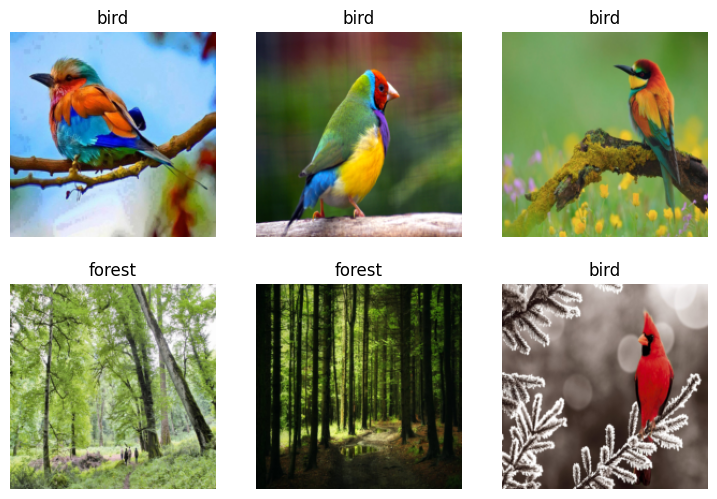

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # input - image; output - category
    get_items=get_image_files,                      # get the image file path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),# validation set - 20% of the data
    get_y=parent_label,                             # get the label from path 
    item_tfms=[Resize(192, method='squish')]        # item transform - resize image 192x192
).dataloaders(path)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate) # download model use it for training

learn.fine_tune(3)

/Users/Toby/Documents/GitHub/machine_learning_stuff/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Toby/Documents/GitHub/machine_learning_stuff/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/Toby/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.584802,0.120130,0.053097,03:26


epoch,train_loss,valid_loss,error_rate,time
0,0.063175,0.010634,0.000000,03:46
1,0.032351,0.004873,0.000000,03:29
2,0.020646,0.003357,0.000000,03:32


### Step 3 - Prediction

In [12]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f'This is a {is_bird}.')
print(f'Probability it'' is a bird: {probs[0]:.4f}')

This is a bird.
Probability it is a bird: {probs[0]:.4f}
